In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Explorando políticos y relaciones

La idea es explorar los datos disponibles en la página del congreso para
- Conocer la información disponible
- Recopilar la info relevante

Son páginas distintas para [senadores](http://www.senado.cl/) y [diputados](http://www.camara.cl/)


La dataframe ``df_senators`` tiene la info consolidad que se le va adicionando según se colecciona nueva info

## TODO

- [ ] Normalizar spanglish (dificil por los elementos en español)


## Senadores
- [X] listado de senadores con datos de partidos

Asistencia y gastos
- [X] asistencia a sala
- [X] asistencia a comisiones
- [X] gastos en personal de apoyo
- [ ] gastos de asignaciones

Votaciones
- [ ] el [partidopirata.cl](https://www.partidopirata.cl/explorando-datos-de-la-camara-de-diputados-de-chile-manzana-mecanica/) tiene un análisis con las *distancias* entre diputados 

In [2]:
def get_soup(url):
    html = urlopen(url)
    data = html.read().decode('utf-8')
    soup = BeautifulSoup(data, 'lxml')
    return soup
    

# Senadores

## listado de senadores

In [3]:
soup = get_soup(("http://www.senado.cl/appsenado/index.php?mo=senadores&ac=listado"))

In [4]:
soup_senators = soup.find_all('td', {'class': 'clase_td'})

In [5]:
# son pocos senadores (por suerte) asi que me tomo una licencia con los O(n2)
senators_rows = []
senator_row = []
for item in soup_senators:
    if len(item.contents) == 10:
        for i in [0, 3, 5, 8]:
            senator_row.append(item.contents[i].string.strip())
            
    elif len(item.contents) == 2:
        p = item.contents[1]            
        senator_row.append(p.string)
        senators_rows.append(senator_row)
        senator_row = []
        
df_senators = pd.DataFrame(senators_rows, columns=['nombre', 'región', 'circunscripción', 'email', 'partido'])

## Asistencia a sala

In [6]:
soup_sala = get_soup('http://www.senado.cl/appsenado/index.php?mo=sesionessala&ac=asistenciaSenadores&camara=S&legiini=361&legiid=489')

l_sala = soup_sala.find_all('tr', {'align': 'left'})

l_asistencia = [] 
f = lambda i, index : i.contents[index].string.strip()  
# for each tr find its td
for item in l_sala: 
    a = item.find_all('td')
    index = 0
    asistencia = []
    for i in a: # reviewing tag
        if index == 0:
            asistencia.append(f(i, 0))
        elif index == 1:
            asistencia.append(f(i, 1))
        elif index == 2:
            asistencia.append(i.contents[1].string)
        index = index + 1    
    if len(asistencia) > 0:
        l_asistencia.append(asistencia)
df_asistencia = pd.DataFrame(l_asistencia, columns=['nombre', 'asistencias', 'inasistencias justificadas'])


In [7]:
# Total de sesiones
ses = soup_sala.find('h2', {'class': 'serif'})
sesiones = [int(i) for i in ses.string.split() if i.isdigit()]
print('total de sesiones', sesiones)

total de sesiones [95]


In [8]:
df_asistencia.fillna(value=0, inplace=True)
for key in ['asistencias', 'inasistencias justificadas']:
    df_asistencia[key] = pd.to_numeric(df_asistencia[key])
df_asistencia['inasistencias'] = sesiones - df_asistencia['asistencias']
df_asistencia.head()

,nombre,asistencias,inasistencias justificadas,inasistencias
0,"Allamand Zavala, Andrés",85,4,10
1,"Allende Bussi, Isabel",70,26,25
2,"Aravena Acuña, Carmen Gloria",89,0,6
3,"Araya Guerrero, Pedro",79,12,16
4,"Bianchi Chelech, Carlos",94,0,1


In [9]:
assert len(df_asistencia) == 43, 'Son 43 senadores actuales'

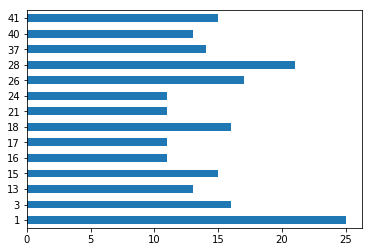

In [10]:
df_senators = pd.merge(df_senators, df_asistencia)
#df_senators = df_senators.set_index('nombre')
df_senators[df_senators.inasistencias > 10].inasistencias.plot(kind='barh')

## asistencia a sala por partido

In [11]:
df_senators.groupby(['partido']).sum()

,asistencias,inasistencias justificadas,inasistencias
partido,,,
Evopoli,84,9,11
Independiente,532,12,38
P.D.C.,448,12,27
P.P.D.,516,15,54
P.S.,597,49,68
Pais Progresista,74,0,21
R.N.,630,12,35
Revolución Democrática,90,3,5
U.D.I.,787,27,68


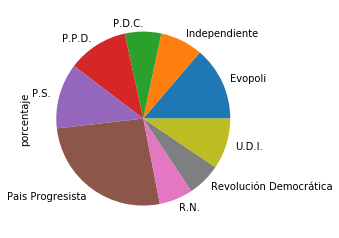

In [12]:
#se define un % de inasistencia sobre el total (suma de asistencias + inasistencias)
df_partidos_asistencia = df_senators.groupby(['partido']).sum()
df_partidos_asistencia['porcentaje'] = (df_partidos_asistencia.inasistencias / (df_partidos_asistencia.inasistencias + df_partidos_asistencia.asistencias) * 100)
df_partidos_asistencia.porcentaje.plot(kind='pie')

## Asistencia a comisiones permanentes
Sobre las comisiones:  https://www.bcn.cl/formacioncivica/detalle_guia?h=10221.3/45759

In [13]:
soup_comisiones = get_soup('http://www.senado.cl/appsenado/index.php?mo=comisiones&ac=asist_x_senador&idsenador=0&ano=2019')

In [14]:
# recolectando id de senador usado en el selector de senadores para pedir la info individual
select_senadores = soup_comisiones.find('select', {'name': 'sel_senador'})
l_asistencia_comisiones = []
for child in select_senadores.findChildren():
    tuple = [child.string, child.attrs['value']]
    l_asistencia_comisiones.append(tuple)
l_asistencia_comisiones
df_asistencia_comisiones = pd.DataFrame(l_asistencia_comisiones, columns=['nombre', 'id_interno'])
df_asistencia_comisiones['id_interno'] = pd.to_numeric(df_asistencia_comisiones['id_interno'])
df_asistencia_comisiones = df_asistencia_comisiones[df_asistencia_comisiones.id_interno > 0]

In [15]:
# quizas se deba normalizar los nombres, por el momento, solo strip
df_senators.nombre = df_senators.nombre.str.strip()
df_asistencia_comisiones.nombre = df_asistencia_comisiones.nombre.str.strip()

In [16]:
# acá el df tiene la info básica y los id de cada senador
df_senators = pd.merge(df_senators, df_asistencia_comisiones, on='nombre')
assert len(df_senators) == 43, 'Se deben mantener 43 senadores después del merge con la asistencia a comisiones'

In [17]:
def procesar_asistencia_comision(soup):
    tds = soup.find_all('td', {'align': {'center'}})
    index = 0
    rows = []
    row = []
    for td in tds:
        row.append(td.string)
        if index == 2:
            rows.append(row)
            row = []
            index = 0
        else:
            index = index + 1
    return rows

soup_columns_comisiones = ['sesiones', 'asistencia', 'justificadas']

lista_senadores = []

# info de cada senadores y sus comisiones usando el id para obtener el soup
for senador_id in df_senators['id_interno']:
    #print('buscando a ', senador_id)
    soup_tmp = get_soup('http://www.senado.cl/appsenado/index.php?mo=comisiones&ac=asist_x_senador&idsenador={}&ano=2019'.format(senador_id))
    rows = procesar_asistencia_comision(soup_tmp)

    df_senador = pd.DataFrame(rows, columns=soup_columns_comisiones)
    
    for column in soup_columns_comisiones:
        df_senador[column] = pd.to_numeric(df_senador[column])
    df_senador['inasistencia'] = df_senador['sesiones'] - df_senador['asistencia']

    #hay errores en la cantidad de sesiones que hace inasistencias negativas, so..
    df_senador.loc[(df_senador['inasistencia'] < 0)] = 0
    #print(df_senador)
    
    # guardamos la cantidad de sesiones y la inasistencia para sacar el %
    l = [df_senador.sesiones.sum(), df_senador.inasistencia.sum(), senador_id]
    lista_senadores.append(l)      
    #print('==========')


In [18]:
df_senadores_total = pd.DataFrame(lista_senadores, columns=['sesiones_comisiones', 'inasistencias_comisiones', 'id_interno'])
df_senadores_total.head()

,sesiones_comisiones,inasistencias_comisiones,id_interno
0,77,12,905
1,105,44,985
2,80,13,1221
3,41,6,1110
4,69,21,907


In [19]:
df_senators = pd.merge(df_senators, df_senadores_total, on='id_interno')
df_senators

,nombre,región,circunscripción,email,partido,asistencias,inasistencias justificadas,inasistencias,id_interno,sesiones_comisiones,inasistencias_comisiones
0,"Allamand Zavala, Andrés",Región Metropolitana de Santiago,7,allamand@senado.cl,R.N.,85,4,10,905,77,12
1,"Allende Bussi, Isabel",Región de Valparaíso,6,iallende@senado.cl,P.S.,70,26,25,985,105,44
2,"Aravena Acuña, Carmen Gloria",Región de la Araucanía,11,cgloriaaravena@senado.cl,Independiente,89,0,6,1221,80,13
3,"Araya Guerrero, Pedro",Región de Antofagasta,3,paraya@senado.cl,Independiente,79,12,16,1110,41,6
4,"Bianchi Chelech, Carlos",Región de Magallanes y la Antártica Chilena,15,cbianchi@senado.cl,Independiente,94,0,1,907,69,21
5,"Castro Prieto, Juan",Región del Maule,9,jcastro@senado.cl,R.N.,87,0,8,1218,59,8
6,"Chahuán Chahuán, Francisco",Región de Valparaíso,6,fchahuan@senado.cl,R.N.,92,3,3,986,74,9
7,"Coloma Correa, Juan Antonio",Región del Maule,9,jcoloma@senado.cl,U.D.I.,90,5,5,687,54,6
8,"De Urresti Longton, Alfonso",Región de Los Ríos,12,adeurresti@senado.cl,P.S.,88,6,7,1115,80,11
9,"Durana Semir, José Miguel",Región de Arica y Parinacota,1,jdurana@senado.cl,U.D.I.,90,2,5,1210,52,3


In [20]:
df_senators.sort_values(by='inasistencias_comisiones', ascending=[False])

,nombre,región,circunscripción,email,partido,asistencias,inasistencias justificadas,inasistencias,id_interno,sesiones_comisiones,inasistencias_comisiones
1,"Allende Bussi, Isabel",Región de Valparaíso,6,iallende@senado.cl,P.S.,70,26,25,985,105,44
42,"Von Baer Jahn, Ena",Región de Los Ríos,12,evonbaer@senado.cl,U.D.I.,93,0,2,1067,106,31
18,"Harboe Bascuñán, Felipe",Región del Bío-Bío,10,fharboe@senado.cl,P.P.D.,79,1,16,1114,96,28
36,"Quintana Leal, Jaime",Región de la Araucanía,11,jquintana@senado.cl,P.P.D.,93,0,2,1008,86,27
19,"Huenchumilla Jaramillo, Francisco",Región de la Araucanía,11,fhuenchumilla@senado.cl,P.D.C.,91,5,4,1222,79,26
40,"Soria Quiroga, Jorge",Región de Tarapacá,2,jsoria@senado.cl,P.P.D.,82,1,13,1213,48,24
15,"Girardi Lavín, Guido",Región Metropolitana de Santiago,7,ggirardi@senado.cl,P.P.D.,80,11,15,909,86,21
4,"Bianchi Chelech, Carlos",Región de Magallanes y la Antártica Chilena,15,cbianchi@senado.cl,Independiente,94,0,1,907,69,21
30,"Ossandón Irarrázabal, Manuel José",Región Metropolitana de Santiago,7,mjossandon@senado.cl,R.N.,91,0,4,1120,72,20
38,"Rincón González, Ximena",Región del Maule,9,xrincon@senado.cl,P.D.C.,91,0,4,1009,92,19


# Personal de apoyo

``df_personal`` **NO** está mezclado con ``df_senator``

In [21]:
soup_personal = get_soup('http://www.senado.cl/appsenado/index.php?mo=transparencia&ac=informeTransparencia&tipo=15&anno=2019&mesid=2')
l_personal = soup_personal.find_all('h1')
lista_personal = []
i_personal = []
for personal in l_personal:
    asignaciones = soup_personal.find('table', {'id': personal.string})
    asignaciones = asignaciones.find_all('tr')
    for asignacion in asignaciones:
        tds = asignacion.find_all('td')
        
        for td in tds:
            if td.string:
                i_personal.append(td.string)
        if tds:
            i_personal.append(personal.string)
            lista_personal.append(i_personal)
            i_personal = []

In [22]:
df_personal = pd.DataFrame(lista_personal, columns=['nombre', 'funcion', 'c. juridico', 'sueldo', 'senador', 'basura'])
df_personal.drop(columns=['basura'], inplace=True)

In [23]:
# Sueldos mas altos
# casi 6 millones un asesor
key = 'sueldo'
df_personal[key] = df_personal[key].replace({',': ''}, regex=True)
df_personal[key] = pd.to_numeric(df_personal[key])
df_personal.sort_values(by=key, ascending=[False])

,nombre,funcion,c. juridico,sueldo,senador
2,"FUENTES BARROS, TOMAS ANDRES",ASESOR PARLAMENTARIO,INDEFINIDO,5900000,ALLAMAND ZAVALA ANDRES
167,"SOLER GARRIDO, ENRIQUE FRANCISCO JOSE",JEFE (A) DE GABINETE,INDEFINIDO,4773938,GUILLIER ALVAREZ ALEJANDRO
385,"FRITES LOPEZ, JORGE",JEFE (A) DE GABINETE,INDEFINIDO,4600150,QUINTEROS LARA RABINDRANATH
349,"MORALES NAVEA, DANIELA CAROLINA",JEFE (A) DE GABINETE,INDEFINIDO,4075313,PROHENS ESPINOSA RAFAEL
1,"BASTIAS OPAZO, ROCIO DEL PILAR",ASESOR (A) POLITICO,INDEFINIDO,3900000,ALLAMAND ZAVALA ANDRES
328,"VALENZUELA SALAZAR, SAMUEL LUIS",ASESOR POLITICO Y ENCARGADO DE PRENSA,INDEFINIDO,3829500,OSSANDON IRARRAZABAL MANUEL JOSE
325,"KING SUAU, MARIA PAZ",SECRETARIA (O) DE PARLAMENTARIO,INDEFINIDO,3814801,OSSANDON IRARRAZABAL MANUEL JOSE
331,"LAMA BENAVIDES, HERNAN MANUEL",COORDINADOR (A) TERRITORIAL,INDEFINIDO,3754463,PEREZ VARELA VICTOR
87,"COUSINS HURTUBIA, PAMELA ELIZABETH",ASESOR (A) DE PRENSA Y JEFE (A) DE GABINETE,INDEFINIDO,3726000,DURANA SEMIR JOSE
407,"BELTRAN GACITUA, CRISTIAN GUILLERMO",ASESOR (A) JURIDICO,INDEFINIDO,3674250,SORIA QUIROGA JORGE
